# Constructing Delta Neutral Straddles in Python

## Imports

- Calling libraries required for dependency injection later in the script
- Dependency injection is effectively calling a pre-made function in python in order to use it in your code

In [ ]:
import pandas_datareader.data as web
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import opstrat as op
from scipy.stats import norm

## Stock Analysis

- Here we are pulling stock prices from Yahoo Finance to later calculate our ATM Call and Put option prices
- We are using black scholes model for option pricing 
- Risk free rate will be 10y UST yield pulled from Yahoo Finance
- Volitility will be S&P VIX multiplied by the relvant stock's beta (I have taken beta from yahoo finance manually as they no longer allow for this to be automated)
- Term will be 3m or 90 DTE
- NOTE - You will find that my options price is as close to live options chain as possible as we had to effectively interpolate our own volitility instead of assuming 20% (one of the major flaws of Black Scholes)

In [2]:
ticker = "AAPL"

beta = 1.27
stock = yf.Ticker(ticker)
latest_price = stock.history(period='1d')['Close'][0]
price = round(latest_price, 2) 

input = "^TNX"
output = yf.Ticker(input)
latest_price2 = output.history(period='1d')['Close'][0]
rate = round(latest_price2, 2) 

input2 = "^VIX"
output2 = yf.Ticker(input2)
latest_price3 = output2.history(period='1d')['Close'][0]
vol = round(latest_price3, 2) 

print (ticker,"Price:",price)
print (ticker,"Beta", beta)
print ("Risk Free Rate:",rate)
print ("Volatility:",vol*beta)

St = price
K = price
r = rate
T = 90
v= (vol*beta)

call=op.black_scholes(K=K, St=St, r=r, t=T, v=v, type='c')
print('3M ATM Call Price:',(call['value']['option value']))

put=op.black_scholes(K=K, St=St, r=r, t=T, v=v, type='p')
print('3M ATM Put Price:',(put['value']['option value']))

AAPL Price: 140.95
AAPL Beta 1.27
Risk Free Rate: 3.45
Volatility: 24.8666
3M ATM Call Price: 7.522857037255022
3M ATM Put Price: 6.328902223325763


## Portfolio Construction

- Now that we know the stocks current, ATM Call and ATM Put option prices, we can construct a delta neutral straddle (long/short) trade in AAPL
- Below, you can see that given the level of volitily, this straddle is expencive to set up and hence not worth the risk.

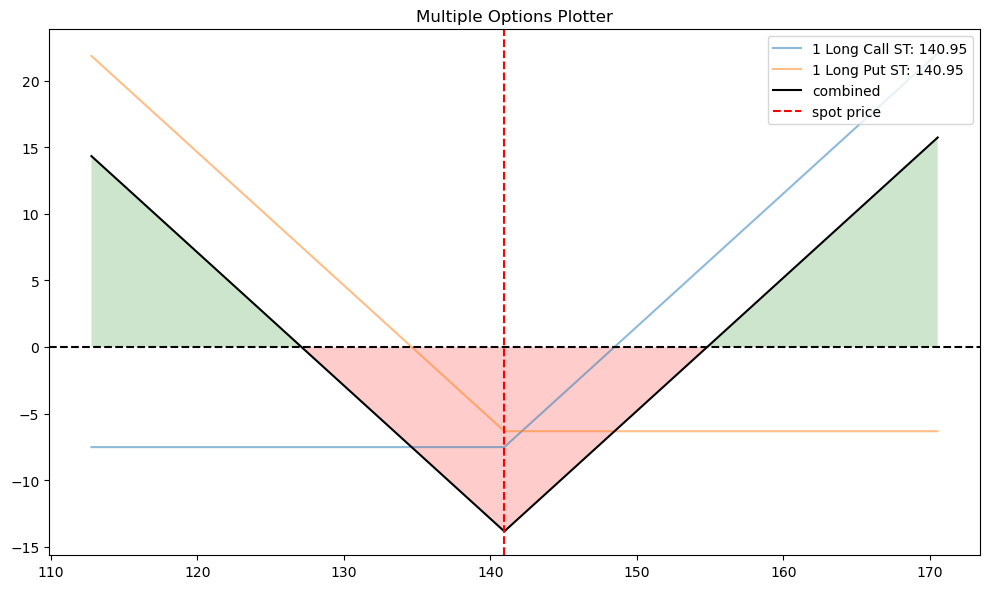

In [3]:
op_1 = {'op_type':'c','strike':price,'tr_type':'b','op_pr':(call['value']['option value'])}
op_2 = {'op_type':'p','strike':price,'tr_type':'b','op_pr':(put['value']['option value'])}
op.multi_plotter(spot=price, op_list=[op_1,op_2])

## The Greeks

- In order to know that we are truly delta neutral, we can calculate the ATM Call and ATM Put Option deltas
- Below you will see we are as good as delta neutral (0.55+-0.45 = 0.1) 

In [4]:
print('Call Delta is:',call['greeks']['delta'])
print('Put Delta is:',put['greeks']['delta'])

Call Delta is: 0.5519670301862634
Put Delta is: -0.4480329698137366


## Monte Carlo Simulation

- Finally, we run a monte carlo simulation for our stock to see expected outcomes accross the return distribution

[*********************100%***********************]  1 of 1 completed


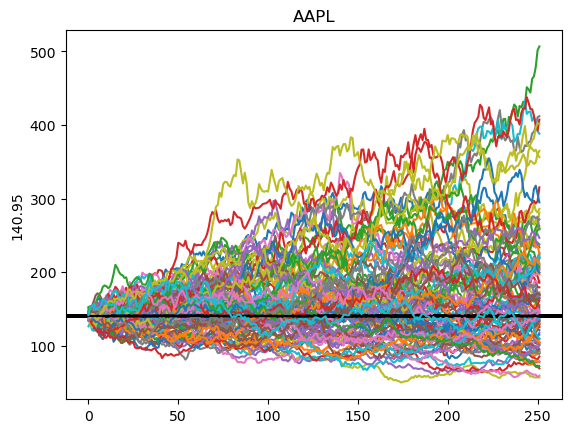

In [5]:
df = yf.download(ticker)
returns = np.log(1+df['Adj Close'].pct_change())
mu, sigma = returns.mean(), returns.std()
sim_rets = np.random.normal(mu,sigma,252)
initial = df['Adj Close'].iloc[-1]
sim_prices = initial * (sim_rets + 1).cumprod()

for _ in range(100):
    sim_rets = np.random.normal(mu,sigma,252)
    sim_prices = initial * (sim_rets + 1).cumprod()
    plt.axhline(initial,c='k')
    plt.plot(sim_prices)
    plt.ylabel(price)
    plt.grid()
    plt.title(ticker)

- Summary: We can see that the delta neutral straddle on apple is ineffective right now due to cost (given heightened volatility)
- We need to find stocks with lower volatility in order to find a cost effective straddle to execute.